### NCAI Training Notebook Template note to content creator
The purpose of the NCAI Training Notebook Template is to make sure that material has a uniform appearance and that contain similarly structured material. The main sections are:
* __Overview__ of the broad topic covered
  * __Prerequisites__ for what background information is needed to go through the notebook
  * __Learning outcomes__ from completing the notebook
* The __Tutorial__ with a balance of explanation and activity
* __Exercises__ for students to try that do not have solutions but maybe have an answer or benchmark to facilitate understanding
* __Next steps__ or potential follow on material
* __Examples in NOAA__
* __Data statement__
* __References__


As you fill out your notebook, make sure to delete the suggestion text.

# Classification Modeling for Hazardous Rip Current Prediction

 * Andre van der Westhuysen<sup>1</sup>, Gregory Dusek<sup>2</sup>, Jung-Sun Im<sup>3</sup>, Mike Churma<sup>3</sup>, and John F. Kuhn<sup>4</sup>, Saeideh Banihashemi<sup>1</sup>
 * <sup>1</sup>NOAA/NWS/NCEP Environmental Modeling Center, <sup>2</sup>NOAA/NOS/CO-OPS, <sup>3</sup>NOAA/NWS/Meteorological Development Lab, <sup>4</sup>NOAA/NWS/Analyze, Forecast and Support Office
 * Version 0.1

---


## Overview
This notebook explores binomial (two classes) classification modeling, using as application area the prediction of hazardous rip currents in San Diego, CA. Rip currents are the leading source of drownings on U.S. beaches, with approaximately 100 fatalies per year. However, it is computationally expensive to predict usng traditional physics-based models that resolve the detailed fluid dynamics that create the rip current structures. Instead, turning the prediction problem into a classification task using ML methods provides actionable guidance to NOAA forecasters at low computational cost.

### Prerequisites
The student is assumed to have a basic understanding of statistics, in particular of linear regression. Fluency in Python and data manupulation with Pandas is assumed.

### Learning Outcomes
From this notebook, the student will learn:
- How a geophyscal modeling task can be restated as a classification problem, and how it can be solved using different ML models.
- How to collect, clean, and transform the environmental data needed to solve the classification problem.
- How to compare the quality of different classification models.
- How to set a probability threshold for identifying events, based on a trade-off between precision and recall.

Upon completion of this training, the student will be able to:
- Identify when a given geophysical problem can be cast as a classification problem.
- Locate, load and manipulate the necessary data for classification.
- Employ and evaluate different ML models to solve the classification problem.
- Quantify the performance of different ML classification models in terms of practical metrics such as the percentage of positive events detected (recall), and the accuracy rate of positive predictions (precision).

---



## Tutorial Material
Content or sections to incorperate here
### 1. Background
  * Science problem: Bathymetry-driven rip currents are caused by variations in the nearshore bathymetry, causing shoaling waves to break unevenly along the coastline. This results in uneven regions of wave-driven setup, which causes focussed return currents, known as rip currents. These phenomena are small scale and transient, making them challenging and computationally expensive to predict with traditional physics-based numerical weather prediction models.
  * ML problem: In order to provide NOAA forecasters with actionable information on rip current hazards, this physics problem is turned into a classification problem. Instead of attempting to predict the *size* and *strength* of the rip current at a beach, we will use classificsation models to predict the *occurence* of a rip current event of sufficient magnitude to cause the average swimmer distress. This classification problem can be addressed with widely-used ML models such as logistic regression and neural networks, as we will see below.

### 2. Basic examples with toy data
We have provided a toy problem demonstrating the basics of classification modeling using logistic regression in a seperate notebook. This simple example, uses the well-known Iris data set (Fisher, 1936), which is a multivariate data set used and made famous by the British statistician and biologist Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis".
You may check out the notebook and practice with the data set if needed, before you proceed to the Rip current prediction problem presented in the next section.

### 3. More complicated example with NOAA data
After reviewing the basic example of the Iris data set, we now investigate the practical problem of identifying hazardous rip currents at a NOAA/NWS Weather forecast Office, using lifeguard reports and NOAA observations. The study site is the San Diego Weather Forecast Office, and specifically rip current detection at Balboa Court, situated along popular Mission Beach (see image).

<img src="img/mission_beach.png" alt="Title" style="width: 400px;"/>

#### 3.1 Load modules
We start by installing the windrose package and loading the required modules for performing the data retrieval, visualization and modeling. 

In [1]:
! pip install windrose

import numpy as np
import pandas as pd
import random as rn

import tensorflow as tf
print('Running on Tensorflow '+tf.__version__)  # Must be Tensorflow 2.x
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from statsmodels.tsa.tsatools import lagmat

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from windrose import WindroseAxes
from pandas.plotting import scatter_matrix

%matplotlib inline
matplotlib.rc_file_defaults()

2022-12-23 21:28:28.239683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running on Tensorflow 2.10.0


We also set random seeds, so that our results will be reproducible.

In [2]:
np.random.seed(2)
tf.random.set_seed(4)
rn.seed(2)

#### 3.2 Data retrieval
We now retrieve the data that will be used in this modeling exercise. This includes (a) the San Diego lifeguard reports of rip current occurrence, (b) the metocean observations from the nearby NDBC 46258 wave buoy, and (c) water level observations at the CO-OPS station 9410230 La Jolla, CA. All of these data sources are read into Pandas dataframes, and some inititial date handling is applied. After reading these, we print out the first five lines of the data sets to start building an understanding what information they contain. In the lifeguard reports, we see the categorical rip current observations 'Rip Current Activity' for each of three lifeguard stations. In the wave buoy data, we see observations of significant wave height (WVHT, in m), dominant/peak wave period (DPD, in s), mean wave period (APD, in s), and mean wave direction (MWD, in degrees TN). In the CO-OPS data, we see the observed water level (WL).

In [3]:
# Read the lifeguard report database
print('Reading lifeguard report')
reports_raw = pd.read_csv('mission_beach_rip_current_reports_v4_corrected.csv', header='infer')
print(reports_raw.head(5))

# Read wave obs data (NDBC 46258 - CDIP 220)
print()
wavdat = pd.DataFrame(columns=['YY','MM','DD','hh','mm','WVHT','DPD','APD','MWD'])
for y  in range(2016,2021):
    year=str(y)
    print('Reading NDBC 46258 for '+year)
    df = pd.read_csv("46258h"+year+".txt", usecols=['#YY','MM','DD','hh','mm','WVHT','DPD','APD','MWD'],
                     skiprows=[1], delim_whitespace=True,na_values=[99.00,999.0])
    df = df.rename(columns={'#YY':'YY'})
    df['Date'] = pd.to_datetime(df['YY'].astype(str)+df['MM'].astype(str).str.zfill(2)+df['DD'].astype(str).str.zfill(2)+' '+df['hh'].astype(str).str.zfill(2)+df['mm'].astype(str).str.zfill(2), format='%Y%m%d %H%M')
    wavdat = wavdat.append(df)
print(wavdat.head(5))

# Read water level obs data (9410230 La Jolla, CA)
print()
wlvdat = pd.DataFrame(columns=['Date','Time (GMT)','Verified (m)'])
for y  in range(2016,2021):
    year=str(y)
    print('Reading CO-OPS 9410230 for '+year)
    df = pd.read_csv("CO-OPS_9410230_met_"+year+".csv", usecols=['Date','Time (GMT)','Verified (m)'], 
                     na_values=[99.00,999.0])
    df = df.rename(columns={'Date':'PDY','Verified (m)':'WL'})
    df['Date'] = pd.to_datetime(df['PDY'].astype(str)+' '+df['Time (GMT)'].astype(str).str.zfill(2), format='%Y/%m/%d %H:%M')
    wlvdat = wlvdat.append(df)
print(wlvdat.head(5))

Reading lifeguard report
            Timestamp Observation Date Observation Time  \
0  6/12/2015 14:16:07        6/12/2015         11:00 AM   
1  6/12/2015 19:37:59        6/12/2015          3:00 PM   
2  6/13/2015 18:39:00        6/13/2013          3:00 PM   
3  6/15/2015 13:39:59        6/15/2015         11:00 AM   
4  6/16/2015 15:18:18        6/16/2015         11:00 AM   

                   Rip Current Activity [Balboa Ct.]  \
0  Some low intensity rip currents present, may b...   
1  Some low intensity rip currents present, may b...   
2  Some low intensity rip currents present, may b...   
3  Very strong rip currents present, hazardous co...   
4  Some low intensity rip currents present, may b...   

             Rip Current Activity [San Fernando Pl.]  \
0  Some low intensity rip currents present, may b...   
1  Some low intensity rip currents present, may b...   
2  Medium to strong rip currents present, will li...   
3  Medium to strong rip currents present, will li...   
4  

/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wavdat = wavdat.append(df)
/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wavdat = wavdat.append(df)


Reading NDBC 46258 for 2018
Reading NDBC 46258 for 2019


/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wavdat = wavdat.append(df)
/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wavdat = wavdat.append(df)


Reading NDBC 46258 for 2020
     YY MM  DD  hh  mm  WVHT    DPD   APD  MWD                Date
0  2016  1  16  15  30  1.28  12.50  8.51  264 2016-01-16 15:30:00
1  2016  1  16  16   0  1.40  12.50  9.31  280 2016-01-16 16:00:00
2  2016  1  16  17   0  1.37  11.76  9.20  275 2016-01-16 17:00:00
3  2016  1  16  17  30  1.42  12.50  9.23  275 2016-01-16 17:30:00
4  2016  1  16  18   0  1.45  12.50  9.22  275 2016-01-16 18:00:00

Reading CO-OPS 9410230 for 2016
Reading CO-OPS 9410230 for 2017
Reading CO-OPS 9410230 for 2018
Reading CO-OPS 9410230 for 2019
Reading CO-OPS 9410230 for 2020
                 Date Time (GMT) Verified (m)         PDY     WL
0 2016-01-01 00:00:00      00:00          NaN  2016/01/01 -0.069
1 2016-01-01 01:00:00      01:00          NaN  2016/01/01 -0.261
2 2016-01-01 02:00:00      02:00          NaN  2016/01/01 -0.396
3 2016-01-01 03:00:00      03:00          NaN  2016/01/01 -0.469
4 2016-01-01 04:00:00      04:00          NaN  2016/01/01 -0.466


/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wavdat = wavdat.append(df)
/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wlvdat = wlvdat.append(df)
/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wlvdat = wlvdat.append(df)
/var/folders/bw/gkhrvc_j1233v4yvrgdqlr_00000gn/T/ipykernel_86821/3910204008.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wlvdat = wlvdat.append(df)
/var/folders/bw/gkhr

As an initial check, we visualize the raw wave observations using wave height and period roses. We see a wave climate of longer period waves, arriving from the S-W sector.

Text(0.5, 1.0, 'NDBC 46258 - Dom. wave period (s)')

<Figure size 640x480 with 0 Axes>

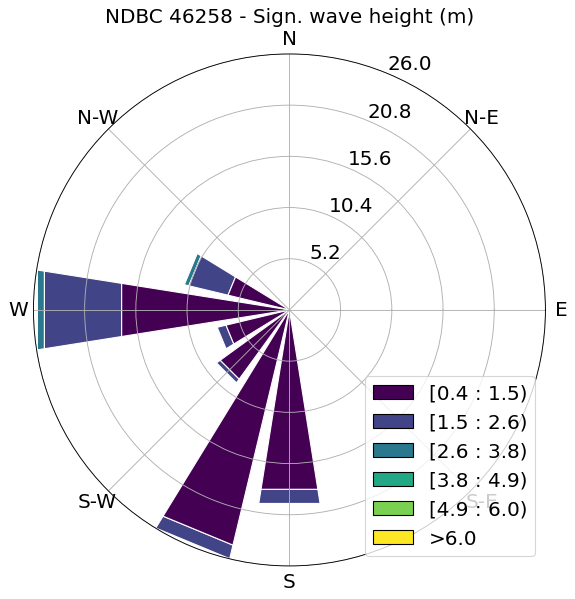

<Figure size 640x480 with 0 Axes>

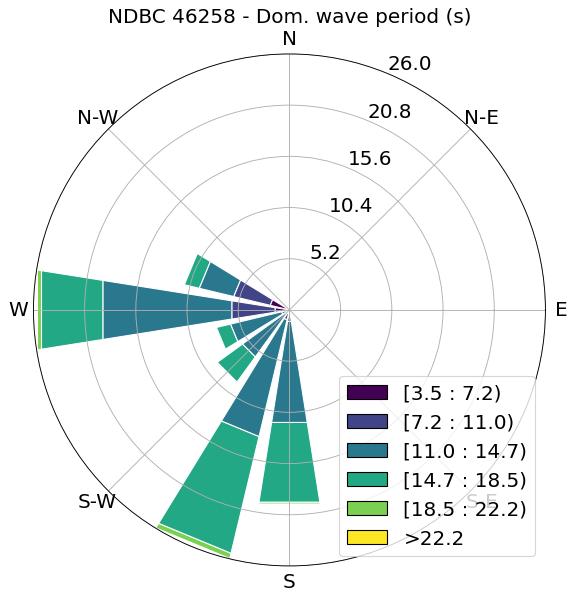

In [4]:
plt.figure()
ax = WindroseAxes.from_ax()
ax.bar(wavdat['MWD'], wavdat['WVHT'], normed=True, opening=0.8, edgecolor='white')
ax.legend(fontsize=18, loc='lower right')
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.title('NDBC 46258 - Sign. wave height (m)', fontsize=18)

plt.figure()
ax = WindroseAxes.from_ax()
ax.bar(wavdat['MWD'], wavdat['DPD'], normed=True, opening=0.8, edgecolor='white')
ax.legend(fontsize=18, loc='lower right')
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=18)
plt.title('NDBC 46258 - Dom. wave period (s)', fontsize=18)

We visualize the raw water level observations using a histogram. It shows an approximately normal, but somewhat asymmetrical, distribution. The mean lies above zero due to the occurrence of storm surge.

Text(0.5, 1.0, 'CO-OPS 9410230')

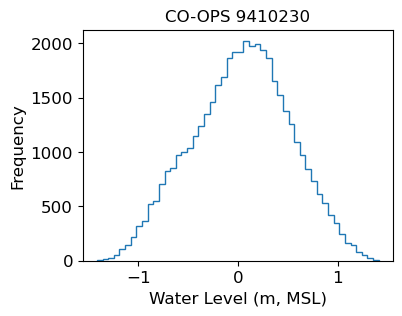

In [5]:
plt.figure(figsize=[4,3])
plt.hist(wlvdat['WL'], bins=50, histtype='step')
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.xlabel('Water Level (m, MSL)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('CO-OPS 9410230', fontsize=12)

#### 3.3 Data selection and cleaning
For this modeling exercise, we will not need all of the information contained in these files, and therefore will to a selection of the relevant data here. Starting with the lifeguard observations, the relevant information includes the observation date and time, and the reported rip current activity at the Bilboa Ct. lifeguard station. For simplicity, the column name is shortened. These lifeguard observations are categorical data. For our ML models, we need to turn these categories into equivalent numerical labels. We clean the data by dropping any records that have missing data (NaNs). The lifeguard reports were collected in local time (Pacific Time), so that the time stamps need to be corrected to a common UTC basis for modeling purposes. The data selection and cleaning of the lifeguard observations is concluded by checking the statistical summary of the data set. We see that there are 1,510 rip current observations (data frame rows), which are recorded at either 04:00 UTC or 08:00 UTC. The categorical rip current observations are now encoded as integers, with a majority class of 2, denoting "Medium to strong rip currents present, will likely be hazardous to swimmers".

In [6]:
reports = reports_raw[['Observation Date', 
                       'Observation Time','Rip Current Activity [Balboa Ct.]']]
reports = reports.rename(columns={"Rip Current Activity [Balboa Ct.]": "Balboa"})

reports = reports.replace('No rips present', 0)
reports = reports.replace('Some low intensity rip currents present, may be hazardous to some swimmers', 1)
reports = reports.replace('Medium to strong rip currents present, will likely be hazardous to swimmers', 2)
reports = reports.replace('Very strong rip currents present, hazardous conditions', 3)
reports = reports.dropna()
reports.Balboa = reports.Balboa.astype(int)

reports['Date'] = pd.to_datetime(reports['Observation Date'].astype(str)+' '+reports['Observation Time'].astype(str), infer_datetime_format=True)
reports['Date'] = reports['Date'] - pd.Timedelta(hours=7)  # Change from local time to UTC

reports = reports[['Date','Balboa']] 

print(reports.shape)
print(reports.head(10))
print(reports.describe())
print('\nClass distribution at Balboa:')
print(reports["Balboa"].value_counts())

(1510, 2)
                 Date  Balboa
0 2015-06-12 04:00:00       1
1 2015-06-11 20:00:00       1
2 2013-06-12 20:00:00       1
3 2015-06-15 04:00:00       3
4 2015-06-16 04:00:00       1
5 2015-06-15 20:00:00       2
6 2015-06-18 04:00:00       1
7 2015-06-17 20:00:00       2
8 2015-06-19 04:00:00       1
9 2015-06-18 20:00:00       2
            Balboa
count  1510.000000
mean      1.693377
std       0.798870
min       0.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       3.000000

Class distribution at Balboa:
2    636
1    553
3    244
0     77
Name: Balboa, dtype: int64


We visualize this categorical rip current occurence data using bar charts.

Text(0.5, 1.0, 'Balboa Ct. Rip current strength')

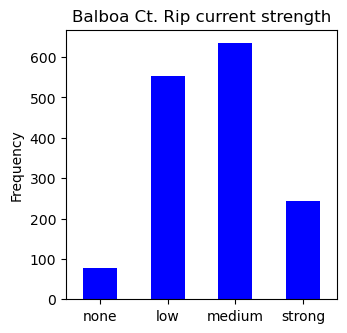

In [7]:
plt.figure(figsize = [3.5, 3.5])
ax = reports['Balboa'].value_counts().loc[[0, 1, 2, 3]].plot.bar(rot=0, color='blue', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
ax.set_xticklabels( ("none", "low", "medium", "strong") )
plt.title('Balboa Ct. Rip current strength')

Next, we perform data selection and feature engineering on the wave observations. Relevant data columns are selected, a log transform is applied to the significant wave height, and the wave direction is converted as an absolute values deviation from the shore normal vector. We also compute a so-called event index, which is set to unity if a storm wave height of 1 m or more occurred anytime during the previous 72 h. In order to model the temporal gradients in the wave parameters, we add lagged values to the data set. From the data summary, we see that there are 83631 observations (dataframe rows), typically taken every 30 min.

In [8]:
# Select relevant columns
wavdat = wavdat[['Date','WVHT','DPD','APD','MWD']]

# Compute event index
WVHT_lag72h = lagmat(wavdat.iloc[:,1], maxlag=144, trim="forward", original='in')  # For 30 min data use 72*2
EP = np.any(WVHT_lag72h[:,1:]>=1.00, axis=1).astype(int)
wavdat.insert(5, 'EP', EP)

# Apply a log transform to WVHT
wavdat['WVHT'] = np.log(wavdat['WVHT'])

# Convert MWD to a deviation from shore normal
wavdat['MWD'] = wavdat['MWD'].astype(float)
wavdat['MWD'] = np.abs(wavdat['MWD']-270.)

# Insert lags
wav_lags = wavdat[['Date','WVHT','DPD','APD','MWD','EP']]
WVHT_lag = lagmat(wavdat.iloc[:,1], maxlag=6, trim="forward", original='in')
wav_lags.insert(2, 'WVHT_lag1', WVHT_lag[:,2])
wav_lags.insert(3, 'WVHT_lag2', WVHT_lag[:,4])
wav_lags.insert(4, 'WVHT_lag3', WVHT_lag[:,6])
DPD_lag = lagmat(wavdat.iloc[:,2], maxlag=6, trim="forward", original='in')
wav_lags.insert(6, 'DPD_lag1', DPD_lag[:,2])
wav_lags.insert(7, 'DPD_lag2', DPD_lag[:,4])
wav_lags.insert(8, 'DPD_lag3', DPD_lag[:,6])
APD_lag = lagmat(wavdat.iloc[:,3], maxlag=6, trim="forward", original='in')
wav_lags.insert(10, 'APD_lag1', APD_lag[:,2])
wav_lags.insert(11, 'APD_lag2', APD_lag[:,4])
wav_lags.insert(12, 'APD_lag3', APD_lag[:,6])
MWD_lag = lagmat(wavdat.iloc[:,4], maxlag=6, trim="forward", original='in')
wav_lags.insert(14, 'MWD_lag1', MWD_lag[:,2])
wav_lags.insert(15, 'MWD_lag2', MWD_lag[:,4])
wav_lags.insert(16, 'MWD_lag3', MWD_lag[:,6])
print(wav_lags.head(10))
print(wav_lags.describe())

                 Date      WVHT  WVHT_lag1  WVHT_lag2  WVHT_lag3    DPD  \
0 2016-01-16 15:30:00  0.246860   0.000000   0.000000   0.000000  12.50   
1 2016-01-16 16:00:00  0.336472   0.000000   0.000000   0.000000  12.50   
2 2016-01-16 17:00:00  0.314811   0.246860   0.000000   0.000000  11.76   
3 2016-01-16 17:30:00  0.350657   0.336472   0.000000   0.000000  12.50   
4 2016-01-16 18:00:00  0.371564   0.314811   0.246860   0.000000  12.50   
5 2016-01-16 18:30:00  0.246860   0.350657   0.336472   0.000000  13.33   
6 2016-01-16 19:00:00  0.300105   0.371564   0.314811   0.246860  12.50   
7 2016-01-16 19:30:00  0.343590   0.246860   0.350657   0.336472  11.76   
8 2016-01-16 20:00:00  0.364643   0.300105   0.371564   0.314811  11.76   
9 2016-01-16 20:30:00  0.314811   0.343590   0.246860   0.350657  12.50   

   DPD_lag1  DPD_lag2  DPD_lag3   APD  APD_lag1  APD_lag2  APD_lag3   MWD  \
0      0.00      0.00      0.00  8.51      0.00      0.00      0.00   6.0   
1      0.00      0.0

Third, we select and clean the water level data. We again compute the lags to represent the temporal change - the rise and fall of the tide. The data summary shows 43,848 hourly water level observations. 

In [9]:
# Select relevant columns
wlvdat = wlvdat[['Date','WL']]

# Insert lags
wlv_lags = wlvdat[['Date','WL']]
WLV_lag = lagmat(wlvdat.iloc[:,1], maxlag=3, trim="forward", original='in')
wlv_lags.insert(2, 'WLV_lag1', WLV_lag[:,1])
wlv_lags.insert(3, 'WLV_lag2', WLV_lag[:,2])
wlv_lags.insert(4, 'WLV_lag3', WLV_lag[:,3])
print(wlv_lags.head(10))
print(wlv_lags.describe())

                 Date     WL  WLV_lag1  WLV_lag2  WLV_lag3
0 2016-01-01 00:00:00 -0.069     0.000     0.000     0.000
1 2016-01-01 01:00:00 -0.261    -0.069     0.000     0.000
2 2016-01-01 02:00:00 -0.396    -0.261    -0.069     0.000
3 2016-01-01 03:00:00 -0.469    -0.396    -0.261    -0.069
4 2016-01-01 04:00:00 -0.466    -0.469    -0.396    -0.261
5 2016-01-01 05:00:00 -0.388    -0.466    -0.469    -0.396
6 2016-01-01 06:00:00 -0.212    -0.388    -0.466    -0.469
7 2016-01-01 07:00:00 -0.015    -0.212    -0.388    -0.466
8 2016-01-01 08:00:00  0.203    -0.015    -0.212    -0.388
9 2016-01-01 09:00:00  0.376     0.203    -0.015    -0.212
                 WL      WLV_lag1      WLV_lag2      WLV_lag3
count  43848.000000  43848.000000  43848.000000  43848.000000
mean       0.032638      0.032659      0.032672      0.032675
std        0.490246      0.490225      0.490216      0.490216
min       -1.415000     -1.415000     -1.415000     -1.415000
25%       -0.306000     -0.306000     -0.

Finally, we merge the various sources into a single data set to be used in our modeling. This merging is done via a database operation called an inner join, in which only the records (observation time stamps) that are common to all the sources are retained. As a result, only records at 04:00 UTC and 08:00 UTC are retained, being the only times at which rip current, wave and water level observations are avaialble concurrently. From the data summary, we see that this reduces the final assembled data set to 995 records.

At this stage, we can also decide to turn the observations from a multi-category to a bimodal data set, by specifying that categories 2 and 3 signify hazardous rip current events, and and categories 0 and 1 signify non-events. This creates our final classification label 'Balboa_binary'. From the mean of this labelled data, we can see that hazardous rip currents (categories 2 and 3) occur 63.5% of the time at Balboa Ct.

In [10]:
# Merge the wave and water level data
wav_wlv = pd.merge(wav_lags, wlv_lags, on='Date', how='inner')
ripdata = pd.merge(wav_wlv, reports, on='Date', how='inner')
ripdata.set_index('Date', inplace=True)

ripdata.loc[(ripdata.Balboa >=2),'Balboa_binary'] = 1
ripdata.loc[(ripdata.Balboa < 2),'Balboa_binary'] = 0
ripdata.Balboa_binary = ripdata.Balboa_binary.astype(int)

print(ripdata.head(10))
print(ripdata.describe())

                         WVHT  WVHT_lag1  WVHT_lag2  WVHT_lag3    DPD  \
Date                                                                    
2016-01-19 04:00:00  0.783902   0.783902   0.760806   0.920283  15.38   
2016-01-19 20:00:00  0.570980   0.570980   0.593327   0.737164  15.38   
2016-01-20 04:00:00  0.698135   0.746688   0.741937   0.693147  14.29   
2016-01-20 20:00:00  0.378436   0.488580   0.488580   0.530628  15.38   
2016-01-21 04:00:00  0.500775   0.246860   0.364643   0.431782  14.29   
2016-01-22 04:00:00  0.314811   0.113329   0.292670   0.412110  14.29   
2016-01-23 20:00:00  0.751416   0.746688   0.712950   0.783902  15.38   
2016-01-24 04:00:00  0.587787   0.647103   0.506818   0.553885  15.38   
2016-01-25 04:00:00  0.431782   0.470004   0.524729   0.657520  11.76   
2016-01-26 20:00:00 -0.010050  -0.020203   0.095310  -0.020203   9.88   

                     DPD_lag1  DPD_lag2  DPD_lag3    APD  APD_lag1  ...  \
Date                                            

#### 3.4 Data visualization
With the data set assembled, we create a scatterplot matrix to better understand the data and correlations. Recall that we identified rip current reports with categories 2 and 3 as hazardous rip current events (Balboa_binary = 1), and categories 0 and 1 as non-events (Balboa_binary = 0). Using the scatterplot matrix, we can investigate wave and water level conditions that lead to these dangerous conditions by color-coding hazardous rip current events red and non-events blue.

array([[<AxesSubplot: xlabel='WVHT', ylabel='WVHT'>,
        <AxesSubplot: xlabel='DPD', ylabel='WVHT'>,
        <AxesSubplot: xlabel='APD', ylabel='WVHT'>,
        <AxesSubplot: xlabel='MWD', ylabel='WVHT'>,
        <AxesSubplot: xlabel='WL', ylabel='WVHT'>],
       [<AxesSubplot: xlabel='WVHT', ylabel='DPD'>,
        <AxesSubplot: xlabel='DPD', ylabel='DPD'>,
        <AxesSubplot: xlabel='APD', ylabel='DPD'>,
        <AxesSubplot: xlabel='MWD', ylabel='DPD'>,
        <AxesSubplot: xlabel='WL', ylabel='DPD'>],
       [<AxesSubplot: xlabel='WVHT', ylabel='APD'>,
        <AxesSubplot: xlabel='DPD', ylabel='APD'>,
        <AxesSubplot: xlabel='APD', ylabel='APD'>,
        <AxesSubplot: xlabel='MWD', ylabel='APD'>,
        <AxesSubplot: xlabel='WL', ylabel='APD'>],
       [<AxesSubplot: xlabel='WVHT', ylabel='MWD'>,
        <AxesSubplot: xlabel='DPD', ylabel='MWD'>,
        <AxesSubplot: xlabel='APD', ylabel='MWD'>,
        <AxesSubplot: xlabel='MWD', ylabel='MWD'>,
        <AxesSubplot: 

<Figure size 640x480 with 0 Axes>

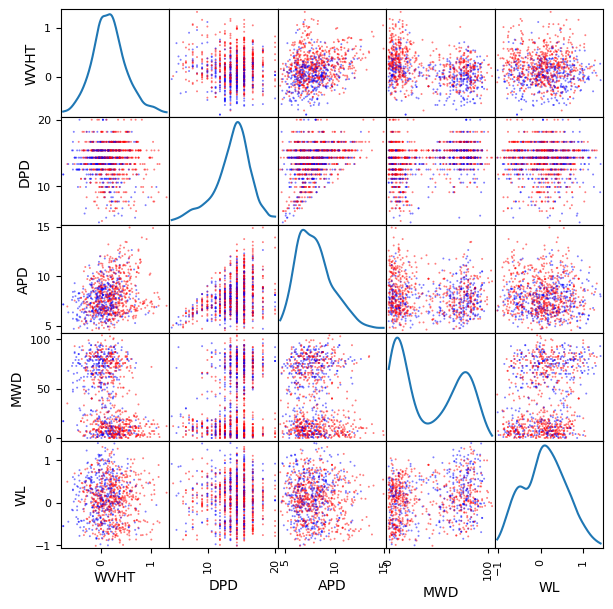

In [11]:
colors=['blue','red']

plt.figure()
scatter_matrix(ripdata[['WVHT','DPD','APD','MWD','WL']], alpha = 0.5, figsize = (7, 7), 
               diagonal = 'kde', s=8, c=ripdata.Balboa_binary.apply(lambda x:colors[x]))

#### 3.5 Data partitioning
To build our ML models, we have to partition the data set into training and test partitions. Since this is time series data, we select the training data from a continuous period, namely 2016-2018. The data from 2019-2020 is selected for the test partition. Because the former period is denser with lifeguard records, the training set contains 730 observations (73% of data) and the test set 265 (27% of data).

In [12]:
#X = ripdata[['WVHT','WVHT_lag1','WVHT_lag2','WVHT_lag3',
#             'DPD', 'DPD_lag1', 'DPD_lag2', 'DPD_lag3',
#             'APD', 'APD_lag1', 'APD_lag2', 'APD_lag3',
#             'MWD', 'MWD_lag1', 'MWD_lag2', 'MWD_lag3',
#             'WL',  'WLV_lag1', 'WLV_lag2', 'WLV_lag3']]
X = ripdata[['WVHT','DPD','MWD','WL','EP']]
y = ripdata[['Balboa_binary']]

train_index = X.index < '2019-01-01 00:00:00'
test_index = X.index >= '2019-01-01 00:00:00'

X_train = X[train_index].to_numpy()
X_test = X[test_index].to_numpy()
y_train = y[train_index].to_numpy().ravel()
y_test = y[test_index].to_numpy().ravel()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(721, 5)
(265, 5)
(721,)
(265,)


#### 3.6 Model building
In this section, we will build various binomimial classication models for predicting hazardous rip currents. For each model type (logistic regression, dense neural net), we will follow the same procedure:
- Fit model using the training data partition.
- Predict the results of the test partition.
- Create a Receiver Operator Curve (ROC) from the predicted probabilities and observed rip currents.
- Select candidate with best Area Under Curve (AUC) as the best classifier for that model type.
- Select optimum probability threshold for identifying rip events, by considering the confusion matrix, precision, and recall.

#### Model 1: Majority class model
As our baseline model we select simple climatology, or the so-called majority class model. This reference model simply always predicts the majority class, and thus its accuracy is the frequency of occurrence of this class. In our case, the frequency of the non-event is slightly greater than 0.5 in the test partition, so the accuracy of our majority class model is 0.509 (or 50.09%). This sets up the target accuracy to be beat with our candidate models.

In [13]:
print('Number of rip events (test data): %.3f' % y_test.sum() )
print('Number of non-events (test data): %.3f' % (len(y_test) - y_test.sum()) )
majority_class_acc = 1.-float(y_test.sum())/float(len(y_test))
print('--- Majority class model ---')
print('> Test Accuracy: %.3f' % majority_class_acc)

Number of rip events (test data): 130.000
Number of non-events (test data): 135.000
--- Majority class model ---
> Test Accuracy: 0.509


#### Model 2: Logistic Regression
As our first candidate model, we will build a logistic regression model. We start by training the model for all five predictors, but we see that WL (x4) and the event parameter Ep (x5) are not significant (p-values > 0.05). From the ROC we see that this classifier has an AUC = 0.745.

Optimization terminated successfully.
         Current function value: 0.567395
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  721
Model:                          Logit   Df Residuals:                      715
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:                 0.09378
Time:                        21:29:26   Log-Likelihood:                -409.09
converged:                       True   LL-Null:                       -451.43
Covariance Type:            nonrobust   LLR p-value:                 8.812e-17
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9074      0.091     10.015      0.000       0.730       1.085
x1             0.5835      0.

Text(0.5, 1.0, 'Balboa: ROC curve - Logistic Regression')

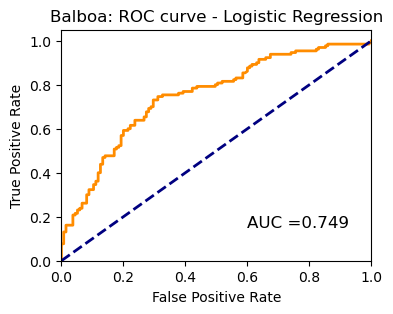

In [14]:
import statsmodels.api as sm
import statsmodels.tools as st
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = st.tools.add_constant(X_train_scaled, prepend=True, has_constant='skip') # Add column for intercept
X_test_scaled = st.tools.add_constant(X_test_scaled, prepend=True, has_constant='skip') # Add column for intercept

logit_model1=sm.Logit(y_train,X_train_scaled).fit()
print(logit_model1.summary())
yhat = logit_model1.predict(X_test_scaled)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Logistic Regression')

Next, we try a second model with only the predictors that were found to be significant: $\ln(\mathrm{WVHT})$, $\mathrm{DPD}$, $\lvert \mathrm{MWD} \rvert$. We select these columns and then refit the model. From the resulting ROC, we see that this model is somewhat better, indicated by a slightly larger AUC of 0.747. We will choose this as our final logistic regression model.

Optimization terminated successfully.
         Current function value: 0.568905
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  721
Model:                          Logit   Df Residuals:                      717
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:                 0.09137
Time:                        21:29:31   Log-Likelihood:                -410.18
converged:                       True   LL-Null:                       -451.43
Covariance Type:            nonrobust   LLR p-value:                 8.942e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9051      0.090     10.039      0.000       0.728       1.082
x1             0.6021      0.

Text(0.5, 1.0, 'Balboa: ROC curve - Logistic Regression')

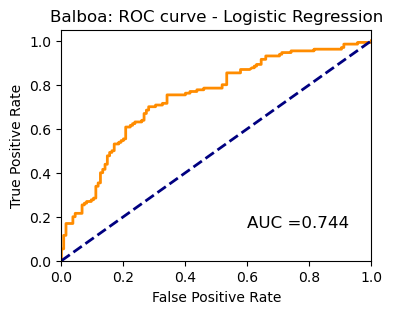

In [15]:
# Select constant and first three predictors
X_train_scaled = X_train_scaled[:,0:4]
X_test_scaled = X_test_scaled[:,0:4]

logit_model1=sm.Logit(y_train,X_train_scaled).fit()
print(logit_model1.summary())
yhat = logit_model1.predict(X_test_scaled)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Logistic Regression')

Having selected our logistic regression model, we now need to select a probability threshold value to identify positive cases (hazardous rip current events). As in our toy example above, we will select this threshold by balancing precision and recall, given the skill of our classification model expressed in its ROC curve. A low threshold will yield high recall, but low precision, whereas a high threshold will yield lower recall, but higher precision. Our first try is with a threshold of P = 0.5. This yields an F1 score of 0.697, and the accuracy of 0.600 is higher than our majority call model (0.509), indicating predictive skill.

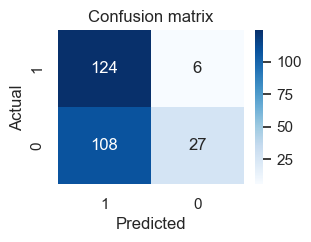

--- Logistic regression model ---
Accuracy: 0.570
Precision: 0.534
Recall: 0.954
F1_score: 0.685
FPR (Type I error): 0.800
FNR (Type II error): 0.046


In [16]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.5

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Next, we try a threshold of P = 0.8. Althougth the accuracy improved to 0.675, the F1 score is poorer at 0.606. The latter is associated with a significantly lower recall of 0.508. This means that about half of hazardous rip current cases would go by undetected, which is unacceptable.

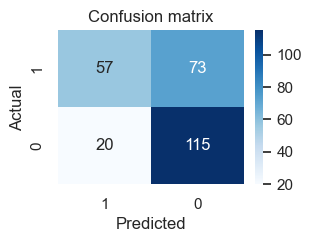

--- Logistic regression model ---
Accuracy: 0.649
Precision: 0.740
Recall: 0.438
F1_score: 0.551
FPR (Type I error): 0.148
FNR (Type II error): 0.562


In [17]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.8

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Finally, we try a threshold of 0.65. This yields the highest F1 score of the three investigated thresholds (0.709), while maintaining an accuracy score of 0.657 and a recall of 0.854. This accuracy score is still higher than that of the majority class model (0.509), indicating that our final logistic regression model has predictive skill. We set this model version as our best logistic regression candidate.

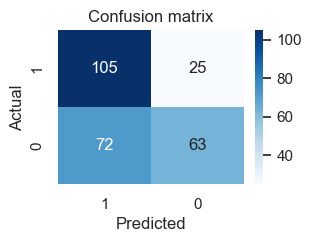

--- Logistic regression model ---
Accuracy: 0.634
Precision: 0.593
Recall: 0.808
F1_score: 0.684
FPR (Type I error): 0.533
FNR (Type II error): 0.192


In [18]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.65

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Logistic regression model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

best_logistic_acc = acc
best_logistic_precision = precision
best_logistic_recall = recall
best_logistic_f1_score = f1_score

#### Model 3: Dense Neural Network
As our second candidate model, we will build a dense neural network. This model achieves an AUC = 0.724, which is somewhat poorer than those of the logistic regression models.

5 1


2022-12-23 21:29:44.194942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 1ms/step
>0.731
5/5 [==============================] - 0s 912us/step
>0.722
5/5 [==============================] - 0s 1ms/step
>0.715
5/5 [==============================] - 0s 974us/step
>0.708
5/5 [==============================] - 0s 1ms/step
>0.667
5/5 [==============================] - 0s 862us/step
>0.766
5/5 [==============================] - 0s 978us/step
>0.646
5/5 [==============================] - 0s 856us/step
>0.701
5/5 [==============================] - 0s 883us/step
>0.653
5/5 [==============================] - 0s 859us/step
>0.688
5/5 [==============================] - 0s 826us/step
>0.710
5/5 [==============================] - 0s 985us/step
>0.688
5/5 [==============================] - 0s 2ms/step
>0.653
5/5 [==============================] - 0s 1ms/step
>0.722
5/5 [==============================] - 0s 1ms/step
>0.681
Model: "sequential_14"
_________________________________________________________________
 Layer (type)          

Text(0.5, 1.0, 'Balboa: ROC curve - Dense NN model (test data)')

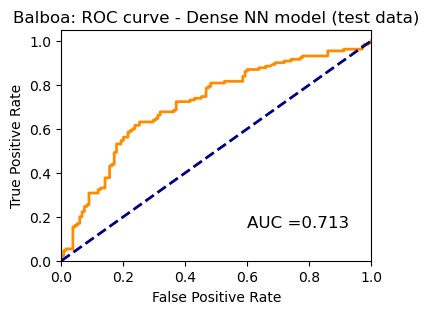

In [19]:
def get_model(n_inputs, n_outputs):
   model = models.Sequential()
   model.add(layers.Dense(8, input_dim=n_inputs, kernel_initializer='he_uniform', 
                           activation='relu', bias_regularizer=regularizers.l2(0.1)))
   model.add(layers.Dense(8, bias_regularizer=regularizers.l2(l=0.1)))
   model.add(layers.Dense(8, bias_regularizer=regularizers.l2(l=0.1)))
   model.add(layers.Dense(n_outputs, activation='sigmoid'))
   model.compile(loss='binary_crossentropy', optimizer='adam')
   return model
 
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
   results = list()
   tn = list()
   fp = list()
   fn = list()
   tp = list()
   n_inputs, n_outputs = X.shape[1], 1
   print(n_inputs, n_outputs)
   # define evaluation procedure
   cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
   # enumerate folds
   for train_ix, test_ix in cv.split(X):
      # prepare data
      X_train, X_test = X[train_ix], X[test_ix]
      y_train, y_test = y[train_ix], y[test_ix]
      # define model
      model = get_model(n_inputs, n_outputs)
      # fit model
      model.fit(X_train, y_train, verbose=0, epochs=500)
      # make a prediction on the test set
      yhat = model.predict(X_test) 
        
      # round probabilities to class labels
      yhat = yhat.round()
      # calculate accuracy
      acc = accuracy_score(y_test, yhat)
      tneg, fpos, fneg, tpos = confusion_matrix(y_test, yhat).ravel()
      # store result
      print('>%.3f' % acc)
      results.append(acc)
      tn.append(tneg)
      fp.append(fpos)
      fn.append(fneg)
      tp.append(tpos)      
   return model, results, tn, fp, fn, tp

# Build and evaluate model
model, results, tn, fp, fn, tp = evaluate_model(X_train, y_train)
model.summary()

# Test the model performance
yhat = model.predict(X_test)

# Compute ROC curve and area under curve (AUC)
n_outputs = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[4,3])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.text(0.6, 0.15, 'AUC ='+'{0:.3f}'.format(roc_auc), fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Balboa: ROC curve - Dense NN model (test data)')

Having selected our dense neural network model, we now need to select a probability threshold value to identify positive cases (hazardous rip current events). We start with a threshold of P = 0.5. This yields an F1 score of 0.697, and a recall of 0.931. The accuracy score of 0.604 is higher than that of the majority class model (0.509), indicsting skill.

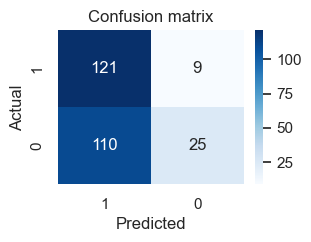

--- Dense NN model ---
Accuracy: 0.551
Precision: 0.524
Recall: 0.931
F1_score: 0.670
FPR (Type I error): 0.815
FNR (Type II error): 0.069


In [20]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.50

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Dense NN model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

Next, we try a threshold of P = 0.55. We see that the F1 score improves to 0.705, and the recall to 0.900, while the accuracy increases somewhat to 0.630. We set this model version to the best dense neural net candidate.

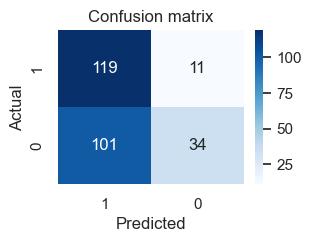

--- Dense NN model ---
Accuracy: 0.577
Precision: 0.541
Recall: 0.915
F1_score: 0.680
FPR (Type I error): 0.748
FNR (Type II error): 0.085


In [21]:
# Set probability threshold for postitive rip event
yhat_class = yhat>0.52

acc = accuracy_score(y_test, yhat_class)
tn, fp, fn, tp = confusion_matrix(y_test, yhat_class).ravel()
precision = (tp/(tp+fp))
recall = (tp/(tp+fn))
f1_score = 2*((precision*recall)/(precision+recall))

import seaborn as sn
df_cm = pd.DataFrame([[int(tp), int(fn)],[int(fp), int(tn)]], [1,0], [1,0])
plt.figure(figsize=(3,2))
sn.set(font_scale=1.0) # for label size
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 12}, cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion matrix")
plt.show()
matplotlib.rc_file_defaults()

# Summarize test performance
print('--- Dense NN model ---')
print('Accuracy: %.3f' % acc)
print('Precision: %.3f' % precision )
print('Recall: %.3f' % recall )
print('F1_score: %.3f' % f1_score )
print('FPR (Type I error): %.3f' % (fp/(fp+tn)) )
print('FNR (Type II error): %.3f' % (fn/(tp+fn)) )

best_nn_acc = acc
best_nn_precision = precision
best_nn_recall = recall
best_nn_f1_score = f1_score

#### 3.7 Model intercomparison
In the modeling section above we built several logistic regression and dense neural net models. In this section we compare their results, to make our final selection of best classification model to indify hazardous rip currents. From this comparison, we see that the best logistic regression model performs somewhat better overall than the best dense neural net model, and would thus be our final model of choice.

In [22]:
print('--- Majority class model ---')
print('Accuracy: %.3f' % majority_class_acc)

print('\n--- Best logistic regression model ---')
print('Accuracy: %.3f' % best_logistic_acc)
print('Precision: %.3f' % best_logistic_precision )
print('Recall: %.3f' % best_logistic_recall )
print('F1_score: %.3f' % best_logistic_f1_score )

print('\n--- Best dense NN model ---')
print('Accuracy: %.3f' % best_nn_acc)
print('Precision: %.3f' % best_nn_precision )
print('Recall: %.3f' % best_nn_recall )
print('F1_score: %.3f' % best_nn_f1_score )

--- Majority class model ---
Accuracy: 0.509

--- Best logistic regression model ---
Accuracy: 0.634
Precision: 0.593
Recall: 0.808
F1_score: 0.684

--- Best dense NN model ---
Accuracy: 0.577
Precision: 0.541
Recall: 0.915
F1_score: 0.680


### Data section, optional
Scripts for pulling the data into the notebook assuming



---


### Exercises
Using the classification models we built above, try the following:
* Select different sets of predictors, for example using lagged variables. Are these statistically significant? Do they improve the quality of the classifiers in terms of the AUC?
* Experiment with different probabiltiy thresholds for identifying events. How does the trade-off between recall and precision change? What do you think would be the best balance of these metrics for forecasting the rip current hazard? 

## Next steps
Now that the student has learned the material, what is the next notebook either in for a series or related material.

## Examples in NOAA

In NOAA operations, a logisitic regression model similar to the one trained above is used for the prediction of hazardous rip currents. The model has been trained by Dusek and Seim (2013) to:

$P\left( y = 1 \lvert g(x) \right) = \dfrac{1}{1+ e^{-g(x)}}$

$g(x) = 1.05 + 3.51\ln(\mathrm{WVHT}) - 0.027\lvert\mathrm{MWD}\rvert + 0.42E_p - 1.70\mathrm{WL}$

Unlike in the tutorial, the input to this classification model is numerical model predictions of significant wave height, mean wave direction, water levels, and the event parameter computed by NOAA's Nearshore Wave Prediction System (NWPS) and Extratropical Surge Operational Forecast System (ESTOFS). This allows the prediction of hazardous rip currents up to 6 days into the future. Thousands of instances of this point-based model have been deployed at 1000-2000 m intervals along U.S. coastlines within NWPS. In the link below, these rip current classifications in three classes (gray=low, yellow=moderate, red=high) are shown. Zoom in and click on an output location to view a time series of the rip current probability for each 6 day forecast:

https://polar.ncep.noaa.gov/nwps/viewer.shtml

## Data statement
Link to the dataset(s) used in the example and/or additional information about the dataset. All data used in these examples should be in the public domain and easily accessable.

## References

If material in the notebook was adapted from other source material for NOAA, link to it.

Also, add other material either cited in the text or that extends content in the notebook.

##Metadata
 * Language / package(s)
 * Domain
 * Application keywords
 * Geophysical keywords
 * AI keywords

## License

### Non-federal creators

#### Software license
Select one of the following open-source, permissive lisences
* GPL
* MIT
* BSD

#### Content/description license
Please select one of the following Creative Commons attribution licenses
* CC BY 4.0

### Federal creators
See the "Disclaimer".


## Disclaimer
This Google CoLab Jupyter is a scientific product and is not official communication of the National Oceanic and Atmospheric Administration, or the United States Department of Commerce. All NOAA Google CoLab Jupyter notebooks are provided on an 'as is' basis and the user assumes responsibility for its use. Any claims against the Department of Commerce or Department of Commerce bureaus stemming from the use of this Google CoLab Jupyter notebook will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.